In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

In [4]:
data_dir = Path('./movie_dataset/')
trn_file = data_dir / 'movies_train.csv'
seed = 42

# time, dir_prev_bfnum, dir_prev_num, num_staff, num_actor, box_off_num 은 수치형 변수로 표현이 되고 있다. realease_date 도 날짜 시간 변수로 표현이 되고 있긴하다. 

In [5]:
df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


# df.info() 를 통해서 결측값을 확인 할수 있고, data type 도 확인이 가능하다. 
# object 을 data type 으로 나타 내는 경우에는 문자열임을 의미하게 되는 것이다. 
왜 dir_prev_bfnum 이 float 실수 일까? 
-> 다른애들은 샘플 갯수가 600 개인데, dir_prev_bfnum 만 270 이다. 이말은 즉슨, 330 개의 데이터가 결측값임을 의미하는 것이다. 결측값이 있는 경우에는 nan 으로 표현이 되는데 얘는 정수가 아니라 실수로 판단을 하게 된다. 그러기 때문에 얘를 실수 data type 이라고 판단을 하는 것이다. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [7]:
df.fillna(0, inplace= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


In [8]:
df.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [9]:
target_col = 'box_off_num'
pred_col = 'pred'
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)


['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


  # x 축은 10^7 승을 의미한다. 즉, 1천 2백만의 사람은 좀 적게 있음을 알수 있다 . 
  # 이렇게 되어 있는 분포는 멱함수 분포라고 표현을 한다.  # 멱함수 분포의 종속 변수를 그대로 선형회귀 모델 학습에 사용한 경우, 예측값에 음수가 존재 하고 적은 값 예측에 오차가 많이 발생한다. 

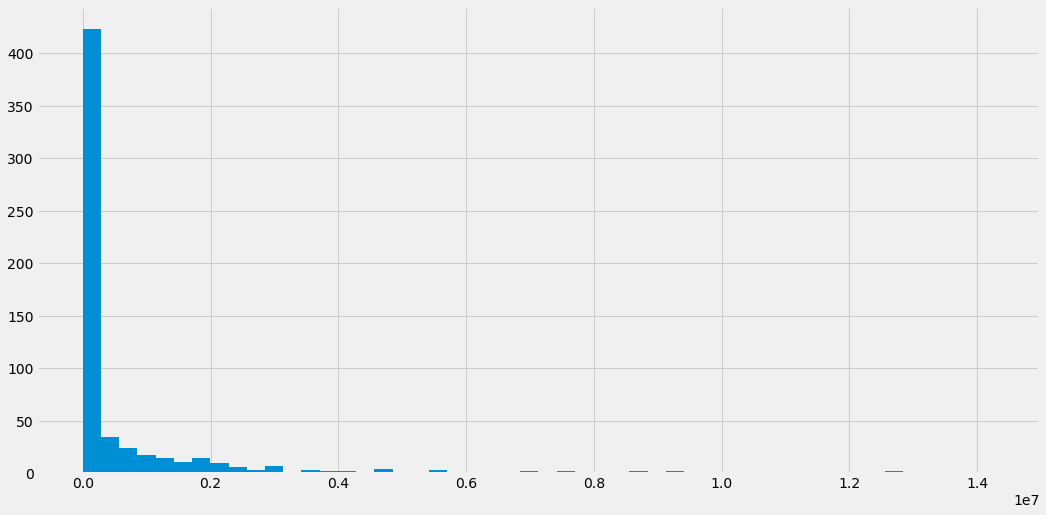

In [10]:
df.box_off_num.hist(bins=50)

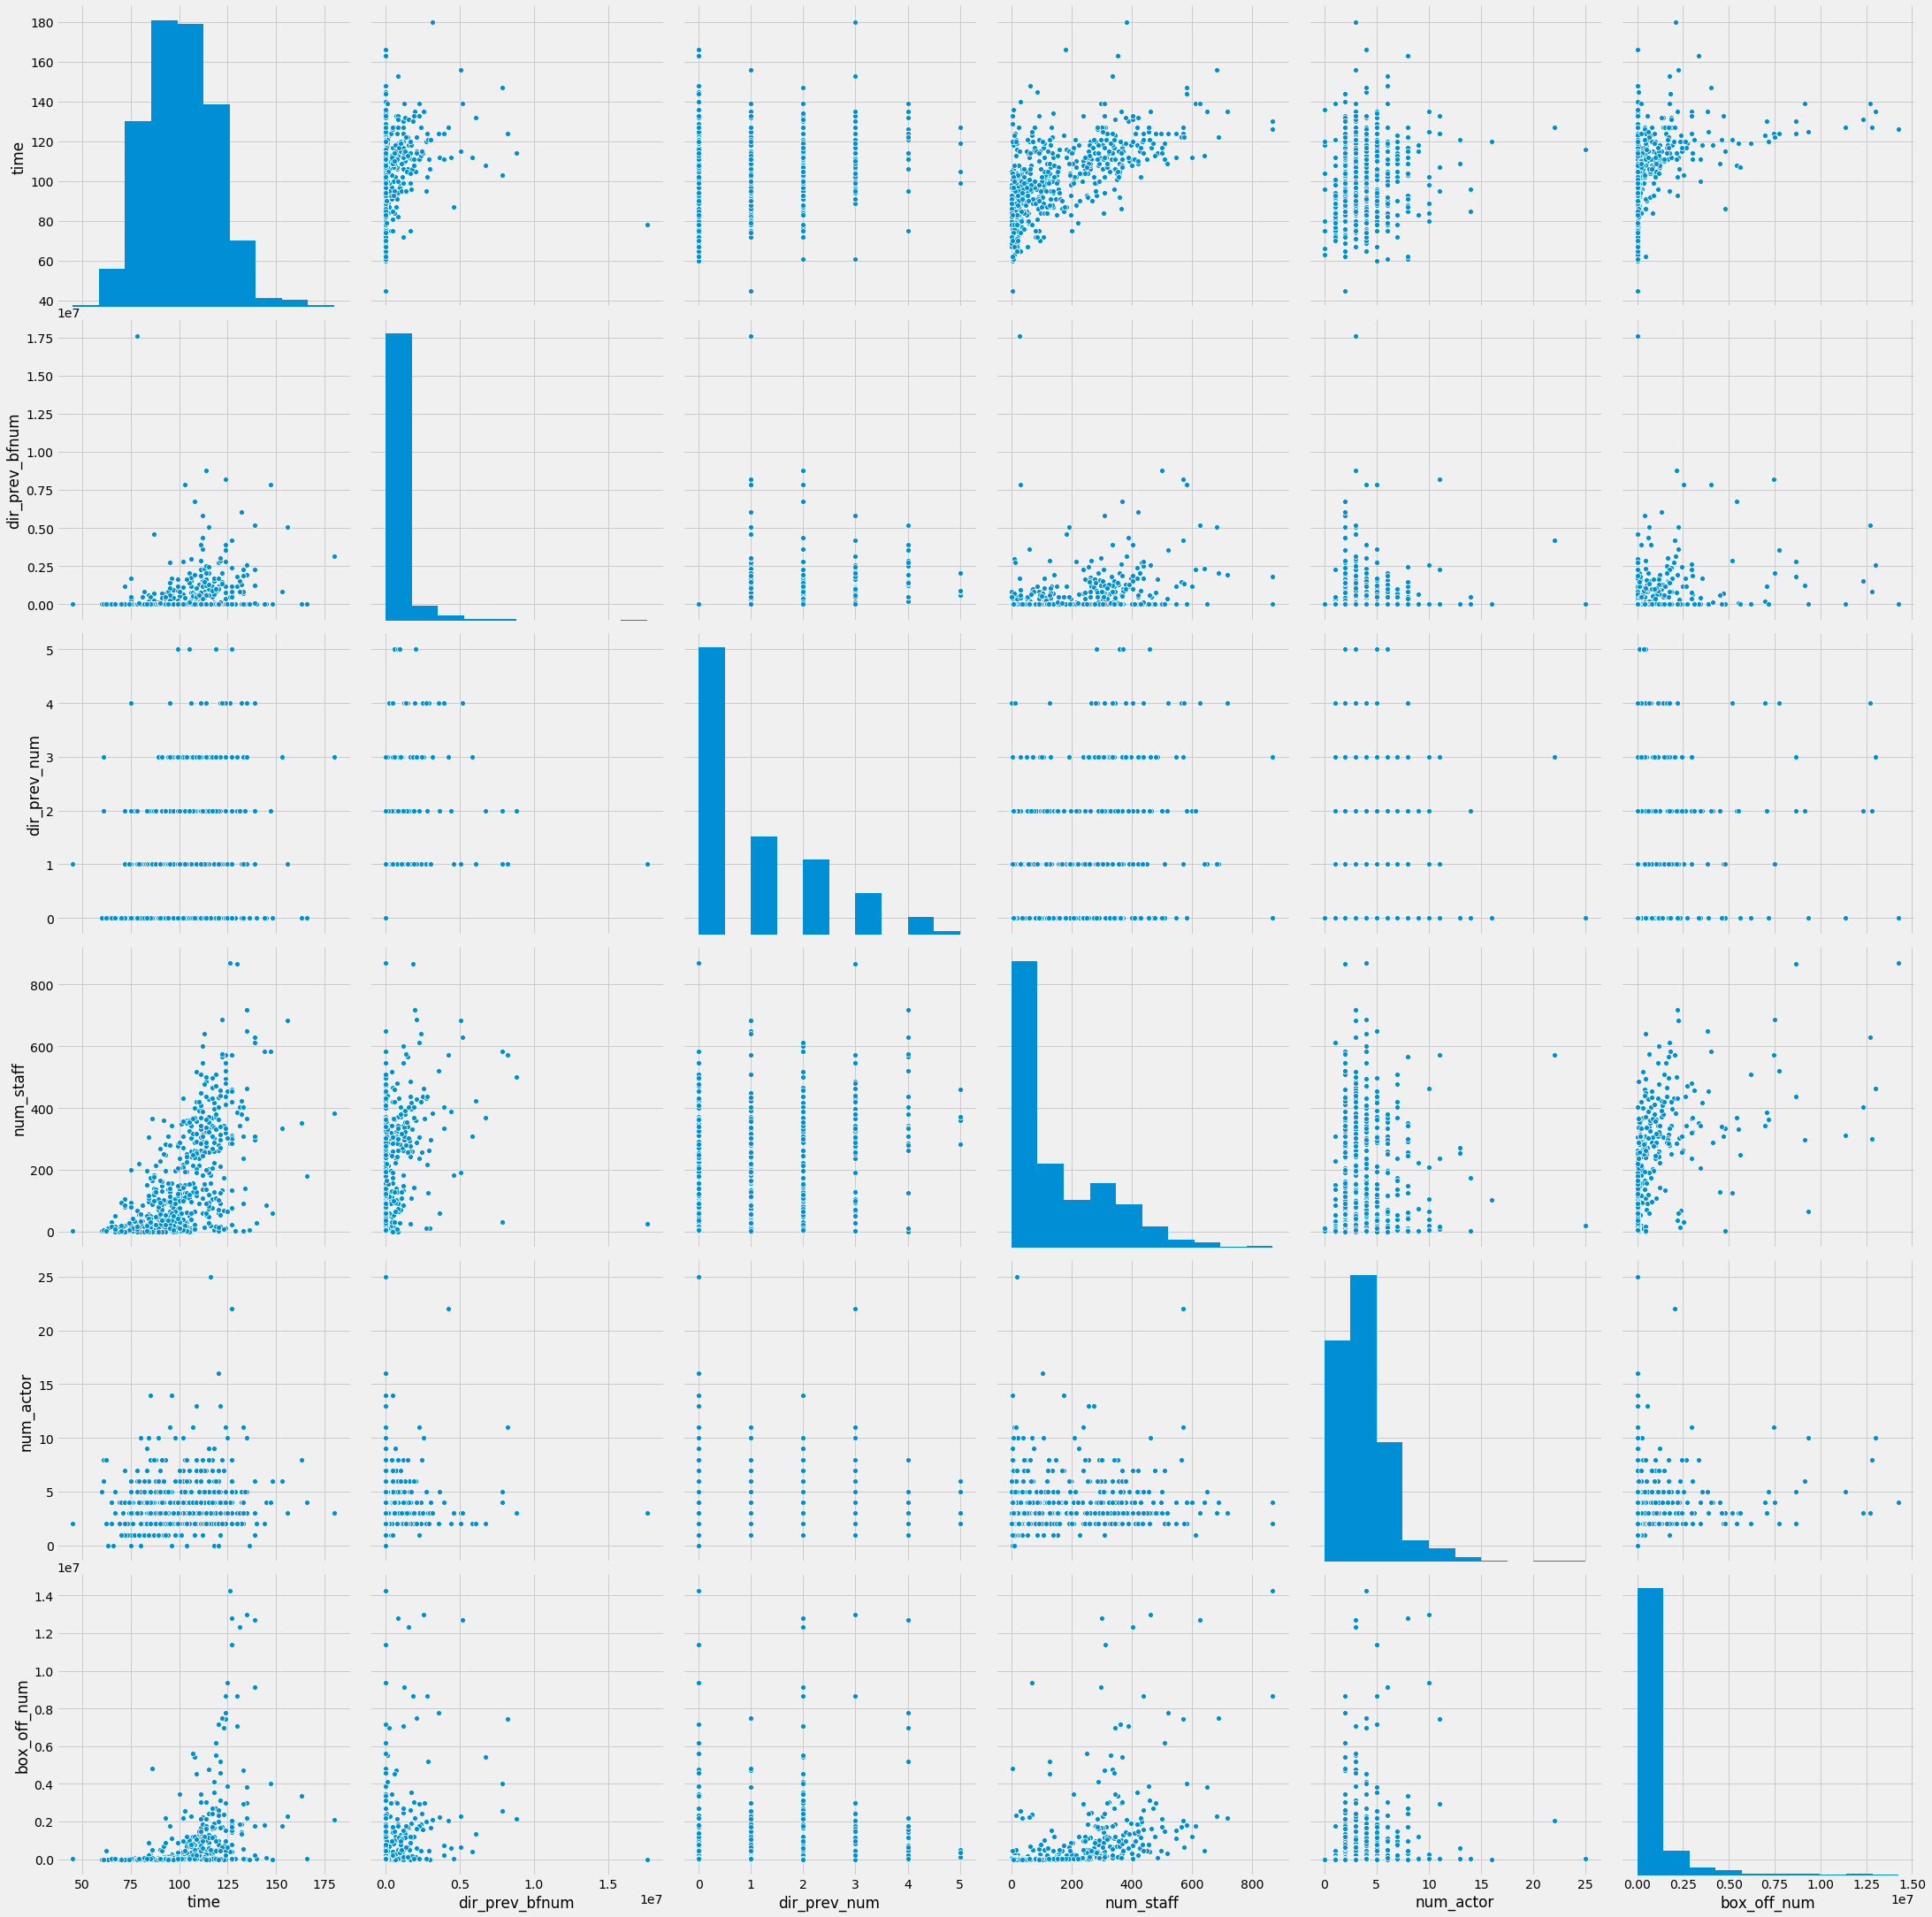

In [11]:
sns.pairplot(data=df, vars=num_cols + [target_col],size=5)

In [12]:
df.corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


# 손실 함수 를 만든다. 루트-민-스퀘어. 
# np.sqrt(mean_squared_error(y,p) )
루트 앞에 씌우고, 진행. y: 실제값, p: 예측값 
y,p 로 에러값에 대해서 rmse 함수를 만든다. 
# rmlse 는 루트 민 로그 스퀘어 에러 값을 의미한다. 
예측값과 실제 값에 log1p 를 각각 적요을 해 주고 그것에 대해서 루트 민 그퀘어 에러를 취하게 되면 이런식으로 변경이 되는 것이다. 



In [13]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmlse = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

# lr.linearregression 
scikitlearn 에 있는 linera regression 함수를 사용하고
# lr. fit(df[num_cols].df[target_col])
target_col 이 박스 오피스 넘버 칼럼, 
num_cols 는 수치형 변수들만 갖고 
fit 선형 회기 모델을 학습 시켰다!
# df[pred_col] = lr.predict(df[num_cols])
num_col (수치형 변수를)을 이용해서 predict 를 하게 되면,
df[pred_col] 같은 데이터 프레임안에서 pred_col 이라는 새로운 칼럼을 만들어서 값을 저장한다. 
라는 의미이다. 
# RMSE 값이 1500066 정도가 나왔다. 
# ideal 한 경우에는 분포는 pred, box_off_num 이 동일하게 나오는 상황이다. 

In [14]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1500066.43


# ideal 한 경우에는 분포는 pred, box_off_num 이 동일하게 나오는 상황이다.
하지만, 낮은 값에 대해서는 좀 값을 잘 예측하지 못하고 있고, (box_off_num& pred) 높은 값에 대해서는 예측을 잘 하고 있따.
그래서 실제 값이 0.2 *10^7 정도 일때 예측값은 얼추 4백만명 까지 (pred) 하고 있다. 
10만명 미만일 때는 2백만 명 정도로 예측하고 있음을 할고 있다 (잘못되게 예측하고 있다!!!)
 # 종속 변수가 멱함수 형태 일때 자주 나오는 현상이다. 
 # 관객수는 음수가 될 수가 없는데, pred 값을 보면 음수 값이 있음을 알 수 있다. 즉 이 값을 그대로 넣어서 문제가 발생하고 잇는 것이다. 

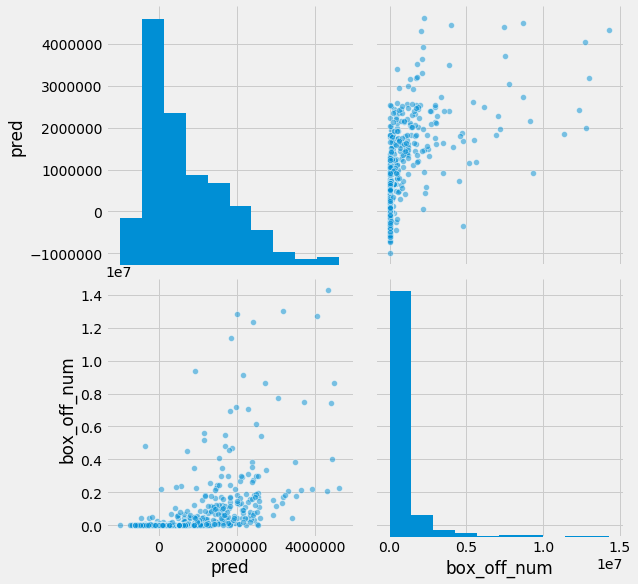

In [15]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

# df.box_off_num.apply(np.log1p) 
를 하게 되면, box_off_num 이라는칼럼 전체에다가 Log1p 를 적용하게 되는 것이다. 
# 그렇게 되면 멱함수 형태 였었던 그래프가 , 약간 정규 분포에 가깝게 그래프가 변경이 된었다. 
이것이 자주 사용하는 방법이다. 
# 왜 그냥 log 만 씌우는 것이 아니라, 1p 를 하는것일까? 
log0 이 마이너스 무한대로 정의가 된기 때문에 그런 것이다. 0 부분은 log0+1 의 로그 값을 취하는 것이기때문에, 그렇게 만드는 것이다. 
# 다시 역변환을 해야되는데 이 때 사용하는 역변환은 expm1 을 사용하는 것이다. 

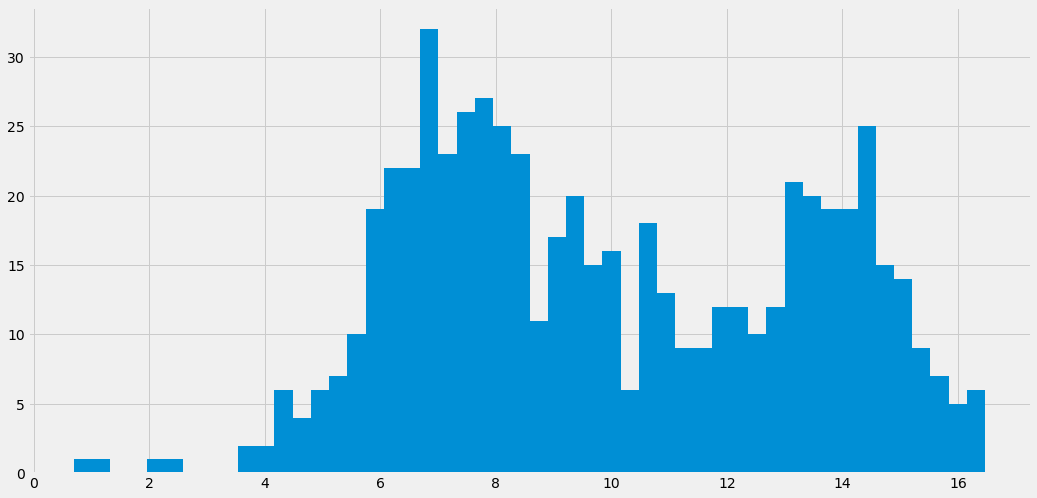

In [16]:
df.box_off_num.apply(np.log1p).hist(bins=50)

# fit -> log1p 변환을 통해서 학습을 하고, 
# 역변환을 시켜서 예측값과 실제값을 로스 스케일로 보여주면, 낮은 값에서도 잘 예측하고 있음을 알수 있게 된다. 
# 이전에는 rmse 값이 1천5백만 정도 였는데, 
이제는 1억 7천만 정도 10배 정도 증가 하게 된것이다. 
왜 그런것인가? 
로그 1p 로 변환을 하는 경우에 가장 큰 값에 대해서는 에러를 더 발생시키게 되는 것이다. 
그리고 낮은 값에 대한 에러는 감소 하게 된다. 
# rmlse 의 경우에는 2.12 로 낮은 값을 보여주게 되는 것이다. 


In [17]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')


 RMSE:	 17129211.69
RMLSE:	        2.12


# 이제 날짜 시간 데이터를 넣어서 학습을 시켜 보자. 

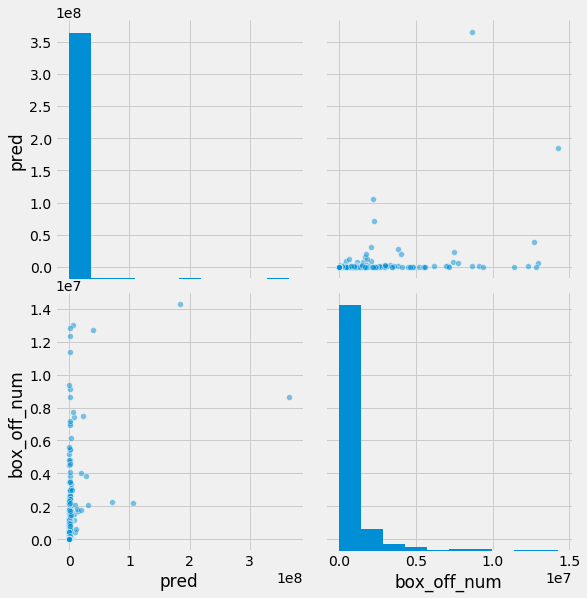

In [18]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})


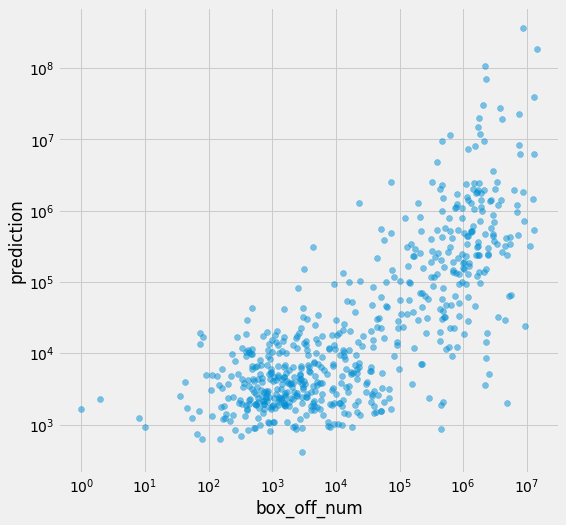

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [20]:
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000


In [21]:
df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']].apply(np.log1p)
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,100.863333,5.305796,0.462197,4.026352,1.446130
std,18.097528,6.254561,0.555570,1.789517,0.446256
min,45.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,2.890372,1.098612
50%,100.000000,0.000000,0.000000,4.424829,1.386294
75%,114.000000,12.837611,1.098612,5.579730,1.609438
max,180.000000,16.684279,1.791759,6.768493,3.258097


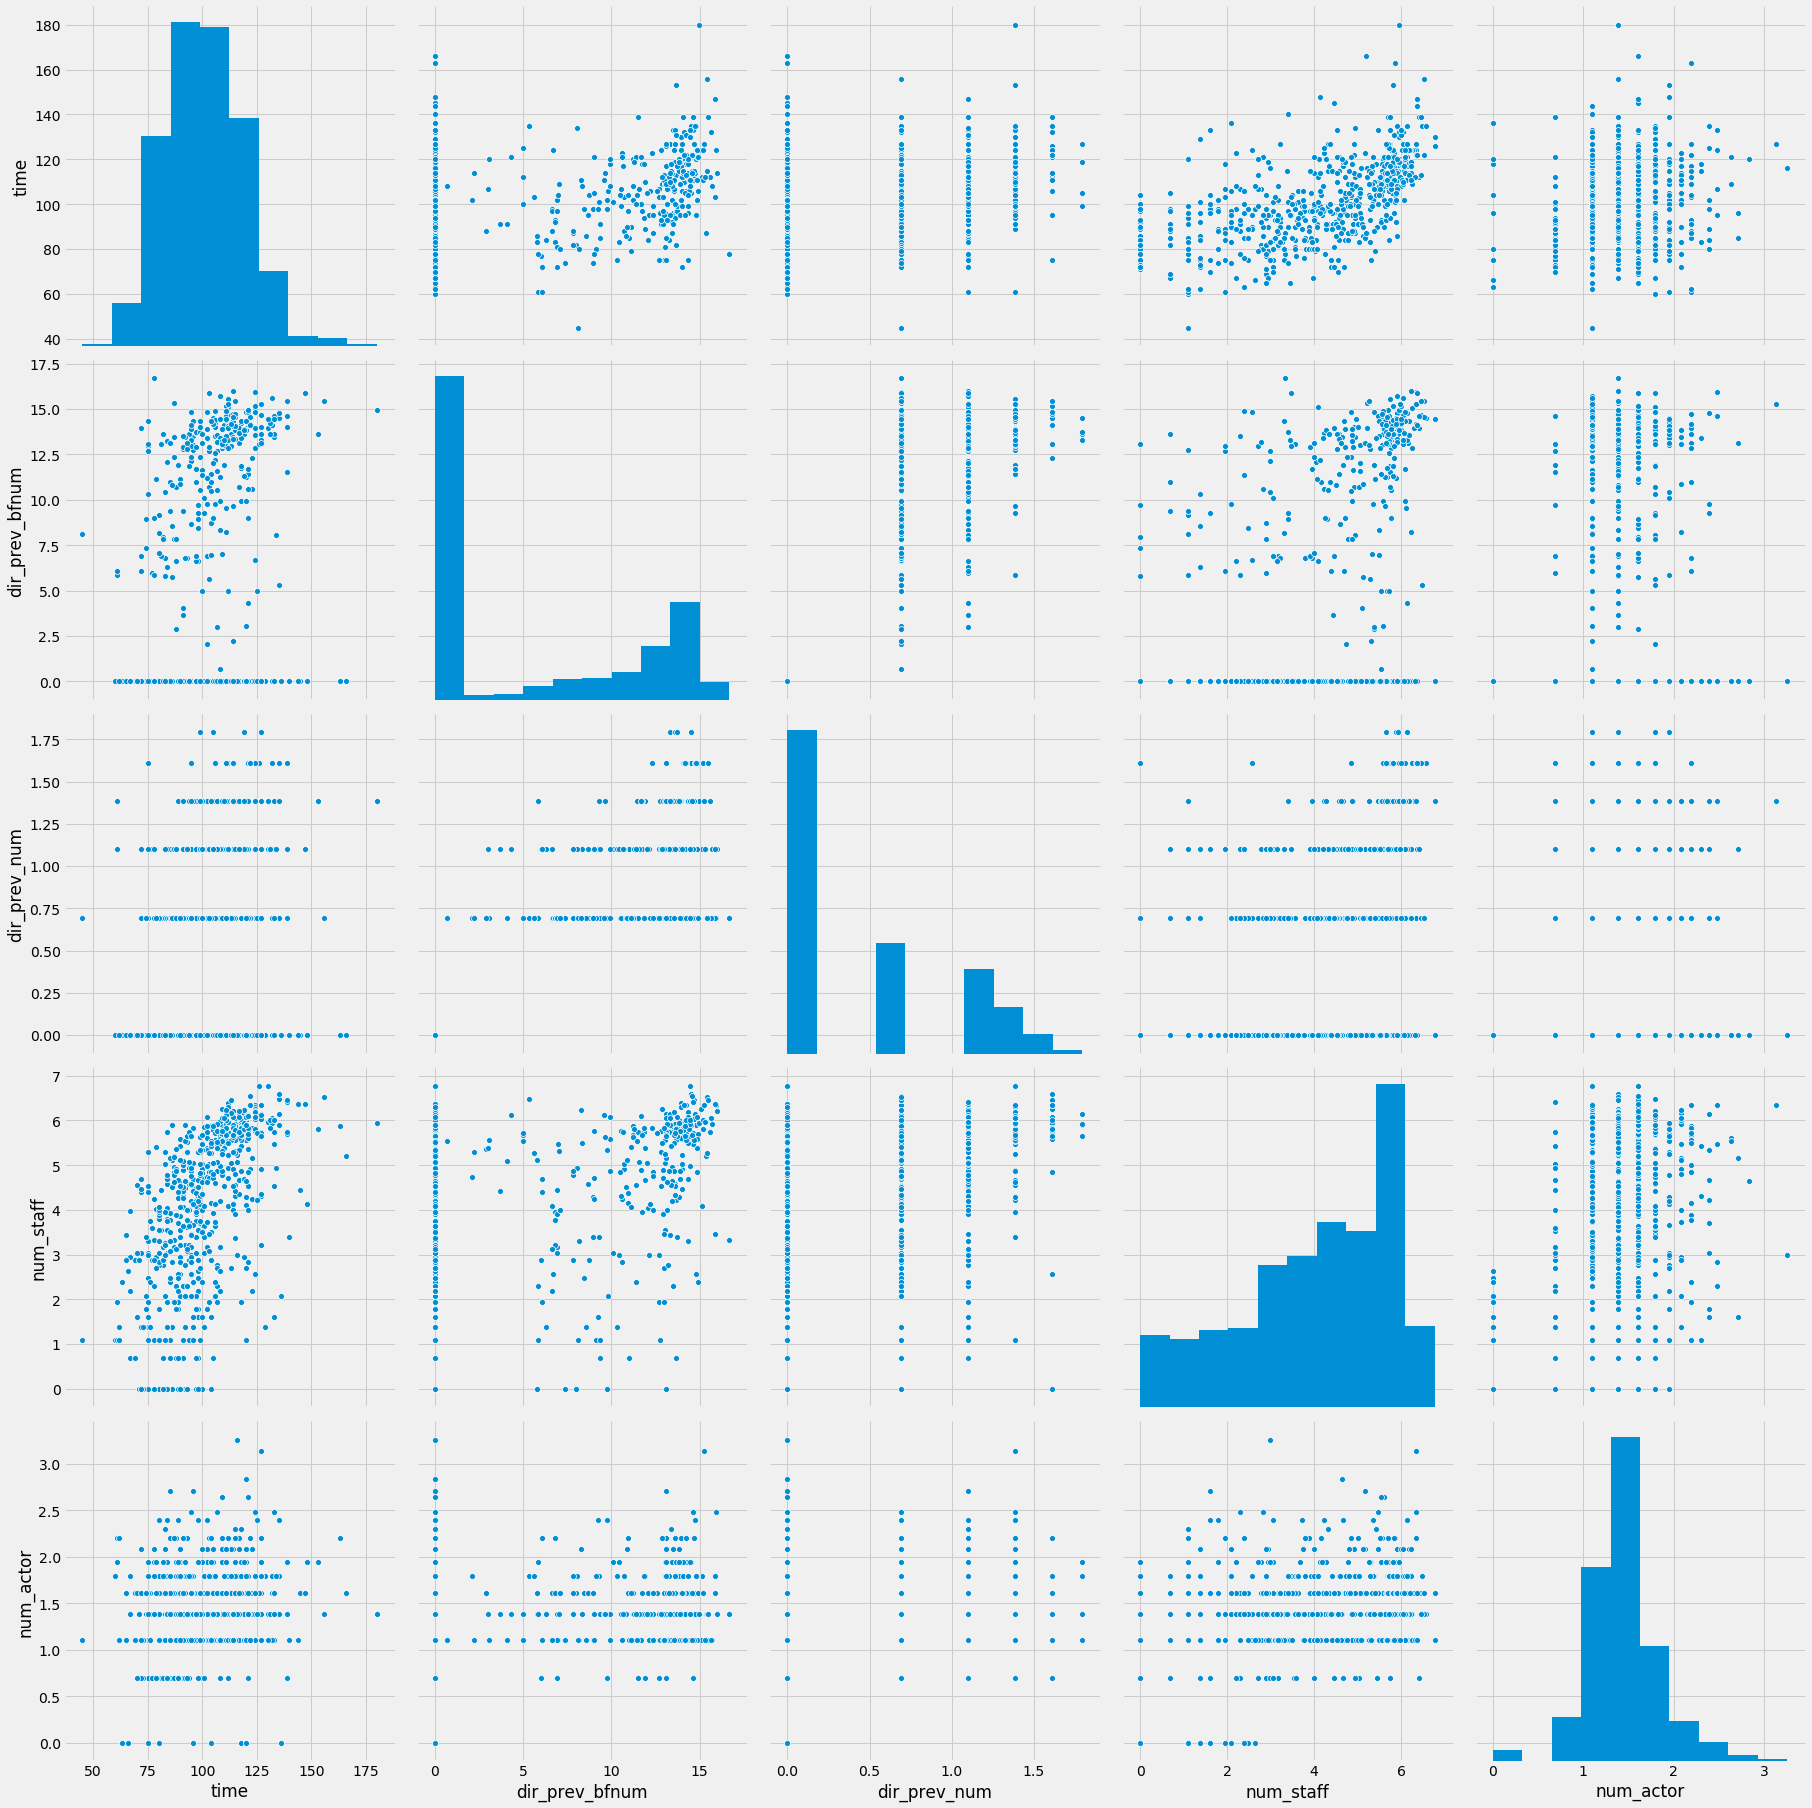

In [22]:
sns.pairplot(data=df, vars=num_cols, size=5)

In [23]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


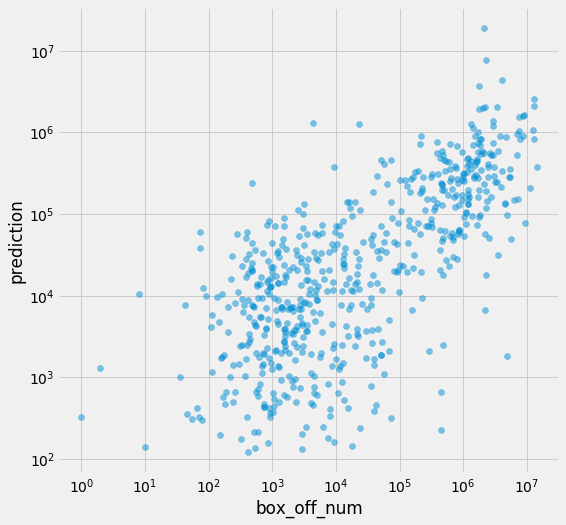

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [25]:
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred
title,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863


# 판다스 를 통해서 연도 관련 된 것을 추출할 수 있게 된다.  상영일 변수를 날짜 시간 변수로 변환을 해 준다음에, describe 를 통해서 분포를 체크 할수 있게 된다. 
시작되는 상영일, 최근 상영일 등을 알 수 있게 되는 것이다. 

In [26]:
df['release_time'] = pd.to_datetime(df['release_time'])
df['release_time'].describe()

count                     600
unique                    330
top       2015-08-13 00:00:00
freq                        6
first     2010-01-02 00:00:00
last      2015-12-31 00:00:00
Name: release_time, dtype: object

# 추출을 한다음에 dt. year 을 통해서 연도를 추출 하여 새로운 칼럼에 저장을 df['year'] 을 하고
# Month 도 동일하게 저장을 하는 것이다. 

In [27]:
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred,year,month
title,,,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433,2012,11
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247,2015,11
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465,2013,6
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119,2012,7
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863,2010,11


# Year, month column 을 수치형 변수에 저장을 하여 뽑아 내게 하는것"

In [28]:
num_cols += ['year', 'month']
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'year', 'month']


# 이 값들을 linaerregression 을 실행하여 뽑아 내서 트래이닝을 시키게 되는 것이다. 
# RMSE 값이 1백 8십만으로 뚝 떨어 짐을 알수 있게 된다. 날짜 를 추가 하기 전에는 1억 7천 이었지만 날자 시간 두개를 추가하여 학습 시켰더니 값이 쭉 떨어짐을 알수 있따. 
# but RMLSE 는 2.2 에서 2.3 으로 사알짝 증가 함을 알 수 있다. 
# 대회에서 는 손실 함수가 하나만 주어지지만, 실무에서는 여러개가 나온다. 하나의 손실함수에 과적합 하는 것을 막기 위해서 일관성있게 perfoming 하는 모델을 선택하기 위해서 다양한 손실 함수를 사용하게 되는 것이다. 
# RMSE 는 감소 하지만, RMLSE 는 약간 증가 함을 알 수 있게 된다. 

In [29]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


# 정규화, 스케일링

# 알고리즘에 다라 수치형 변수를 스케일링/정규 분포화 할 수 있다. 선형 회귀/결정트리 류의 알고리즘에는 도움이 되지 않는다. 왜냐하면, 위의 것들은 스케일링과는 무관하게 학습하기 때문에. 
# 어떤 변수의 크기를 늘리거나 줄이거나 하여 학습 시키는 것이 정규화, 스케일링 이다. 
# 딥러닝/뉴럴 네트워크는 수치형 변수 스케일링이 굉장히 중요하다.
# 이를 하기 위해서는 sklearn.preprocessing 에서 standardscaler, minmax scaler 를 제일 많이 사용하게 된다. 

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 객체를 생성한 다음에, 
# standar scaler 는
# 정규화를 할 수 있다. 평균값을 빼고 그 값을 standard deviation 으로 나눠주면 정규화를 진행 할 수 있는 것이다. 이를 딱 이 두 줄로 사용이 가능하다. 
# 우리는 선형 회귀 모델을 하용하기 때문에 performance 에는 크게 변화가 없음을 알 수 있다. 

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


# minmax scaler 라는 것은 Min, max 를 0,100 으로 고정을 시키는 것이다. 모든 변수를 Max 값으로 나눠서 1 이 나오게 해서 학습을 시키는 것이다. 
# 문법은 동일하고 neural network 에서 굉장히 많이 사용하는 모델이다. 
# 선형 회기 를 사용하기 때문에 RMSE, RMLSE 값이 별로 많이 변형이 안됨을 알수 있게 된다. 

In [32]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


# binning 에 대해서 이제 공부를 해보자. 

# 범주화 시키는 것인데 , 수치형 변수를 binning 을 통해서 범주형 변수로 변환을 시키는 것이다. 

# qcut 이라는 것을 이용해서 최하위에서 최상위 까지 25% 씩 데이터를 4개로 그룹으로 지어서 뽑아 내는 것을 의미한다. 
time 에 대한 그래프가 정규 분포를 따르는 것임을 알 수 있게 된다. 
# 1 사분면의 그래프를 보면, 0-75 가 하나의 버켓, 75-100 이 두번째 100-120 이 세번째 버켓 네번째는 나머지 싹다 이렇게 범주형으로 변환을 시킬 수 있다. 

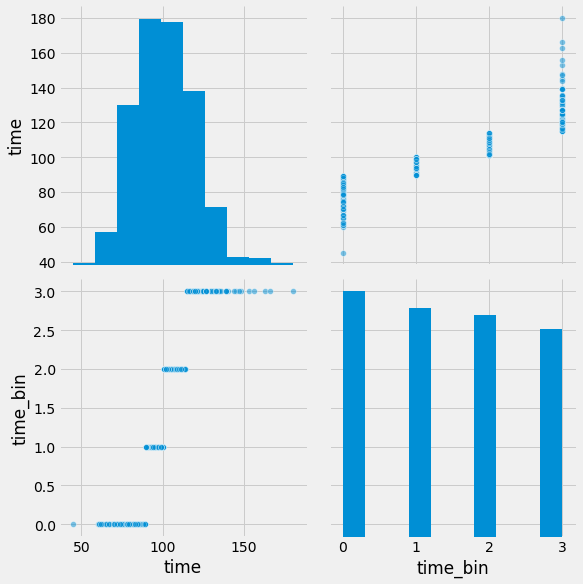

In [33]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
sns.pairplot(data=df, vars=['time', 'time_bin'], size=4, plot_kws={'alpha': .5})

In [34]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
df[['time', 'time_bin']].head(10)

,time,time_bin
title,,
개들의 전쟁,96,1
내부자들,130,3
은밀하게 위대하게,123,3
나는 공무원이다,101,2
불량남녀,108,2
강철대오 : 구국의 철가방,113,2
길위에서,104,2
회사원,96,1
"1789, 바스티유의 연인들",129,3


In [35]:
X = pd.concat([df[num_cols], pd.get_dummies(pd.qcut(df['time'], 4, labels=False))], axis=1)
X.shape

(600, 11)

In [36]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1730191.35
RMLSE:	        2.25


# 이렇게 한 뒤에 get dummies 로 하면 0,1,2,3, 이렇게 독립된 칼럼에 넣게 해 줄수 있게 된다. 
month 를 기준으로 dummy 를 해 주는 것이다. 

In [37]:
X = pd.concat([df[[x for x in num_cols if x != 'month']], 
               pd.get_dummies(pd.qcut(df['time'], 4, labels=False)),
               pd.get_dummies(df['month'])], axis=1)
X.shape

(600, 22)

# dummies 로 하면 값이 굉장히 RMSE RMLSE 가 떨어 짐을 알수 있게 된다. 
# Binning 은 굉장히 많이 사용한다. 
# 데이터가 비선형적으로 되어있을 때 많은 경우 러닝을 향상 시킬 수 있다. 

In [38]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1693164.29
RMLSE:	        2.22


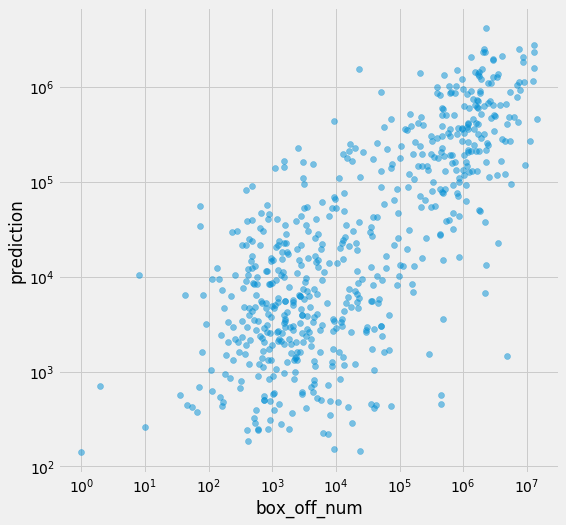

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

# 2차 다항 회귀
변수가 두개 가 있을 때 그 두개로 여러 조합을 해서 수치형 변수를 만들어 내는 것이다. 
1,x1,xw,xq*xw,xq^w/..... n1차 2차 등등을 만들 수 있게 되는 것이다. 
# 데이터가 많을 때는 굉장히 효율적익 사용할 수 있다. 
# 2 차 이상은 추천 안한다. 생성되는 변수가 지수적으로 증가 하기 때문. 

In [40]:
from sklearn.preprocessing import PolynomialFeatures

# polynomialFeature(2) 이렇게 작성하여 2 차 까지만 생성 할 것을 요구 하는 것이다. 
객체를 생성 후 fit_transform 을 통해서 다항회귀 를 적용하게 되는 것이다.
36개의 수치가 형성됨을 알 수 잇따. 

In [41]:
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

(600, 36)


In [42]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2925429.25
RMLSE:	        2.00


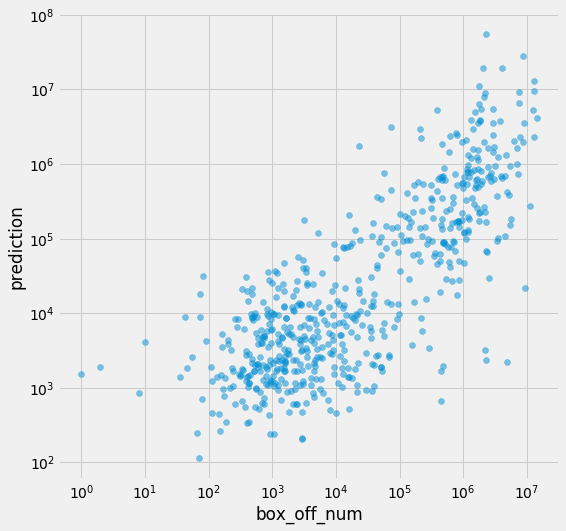

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')